In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [9]:
get_mxmy = re.compile(r'MX_(\d+)_MY_(\d+)')
signal_list = fc.eightb.feynnet_signal_list

In [16]:
masses = np.array([ get_mxmy.findall(f)[0]  for f in signal_list ], dtype=int)

(<Figure size 480x400 with 1 Axes>,
 <AxesSubplot:title={'center':'Training Mass Points'}, xlabel='$M_{X}$ (GeV)', ylabel='$M_{Y}$ (GeV)'>)

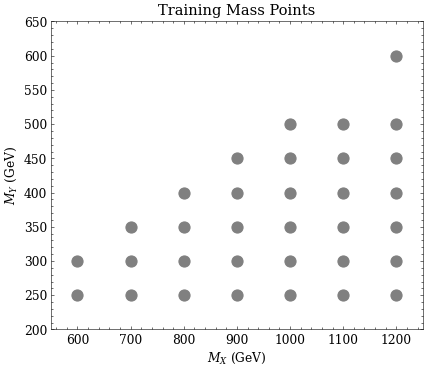

In [27]:
figax = study.get_figax()
mx, my = masses.T
graph_array(
    mx, my,
    g_color='grey', g_ls='none', 
    g_marker='o', g_markersize=10, 
    xlabel='$M_{X}$ (GeV)',
    ylabel='$M_{Y}$ (GeV)',
    xlim=(550,1250),
    ylim=(200,650),

    title='Training Mass Points',

    figax=figax,
    )

In [143]:
module = fc.eightb.accstudies.met.lepveto

f_signal = ObjIter([ f.replace('ntuple','output/ntuple_{0,1,2,3}') for f in module.feynnet_signal_list ])
signal = f_signal.apply(lambda f : Tree(f, report=False), parralel=True, report=True)

100%|██████████| 33/33 [05:51<00:00, 10.67s/it]


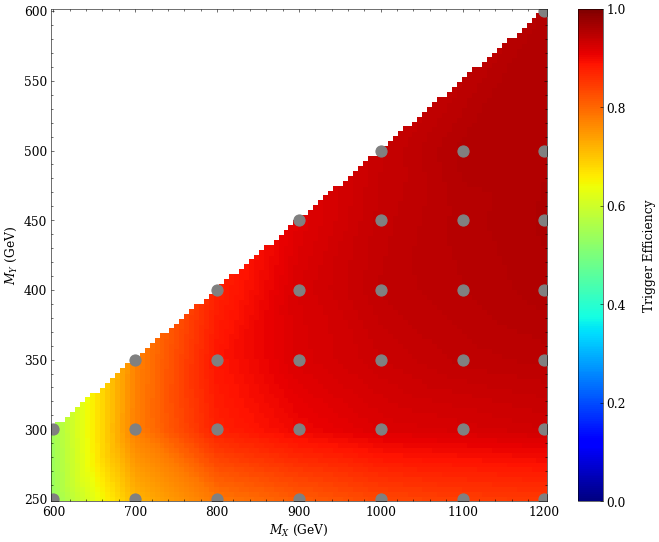

In [144]:
study.mxmy_phase(
    signal,
    f_var=lambda t : ak.mean(t[trigger]),
    # zlim=np.linspace(0,1,11),
    zlim=(0,1),
    g_cmap='jet',
    xlabel='$M_{X}$ (GeV)',
    ylabel='$M_{Y}$ (GeV)',
    zlabel='Trigger Efficiency',
)

In [145]:
argextrema = lambda array : (ak.argmin(array), ak_argavg(array), ak.argmax(array))

In [146]:
def print_extrema(signal, method):
    array = signal.apply(method).npy
    argmin, argavg, argmax = argextrema(array)

    for key, arg in dict(min=argmin, mean=argavg, max=argmax).items():
        print(f'{key}: { signal.mass[[arg]][0] } = {array[arg]:0.2f}')
    return argmin, argavg, argmax

In [147]:
print_extrema(signal, lambda t : ak.mean(t[trigger]))

min: (600, 250) = 0.54
mean: (800, 400) = 0.87
max: (1200, 450) = 0.96


(0, 8, 30)

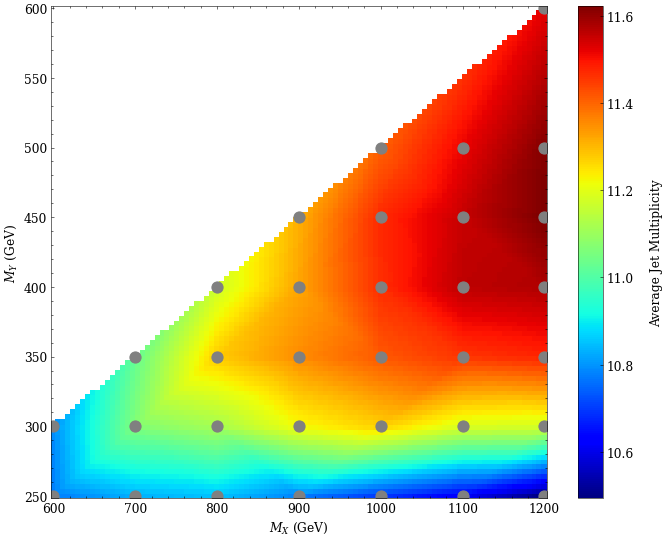

In [148]:
study.mxmy_phase(
    signal,
    f_var=lambda t : ak.mean(t.n_total_jet),
    # zlim=np.linspace(0,1,11),
    # zlim=(0,1),
    g_cmap='jet',
    xlabel='$M_{X}$ (GeV)',
    ylabel='$M_{Y}$ (GeV)',
    zlabel='Average Jet Multiplicity',
)

In [149]:
def nfound_select(t):
    jet_btag = t.jet_btag
    jet_id = t.jet_signalId

    jet_id = jet_id[ak.argsort(-jet_btag, axis=1)]
    nselected = ak.sum(jet_id[:,:8]>-1, axis=1)
    t.extend(nfound_select=nselected)
signal.apply(nfound_select, report=True, parallel=True)

100%|██████████| 33/33 [00:49<00:00,  1.50s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

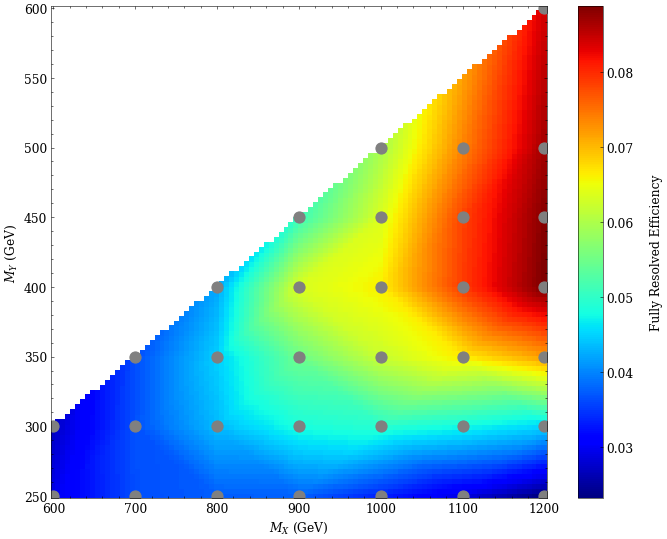

In [152]:
study.mxmy_phase(
    signal,
    f_var=lambda t : ak.mean(t.nfound_select==8),
    # zlim=np.linspace(0,1,11),
    # zlim=(0,1),
    g_cmap='jet',
    xlabel='$M_{X}$ (GeV)',
    ylabel='$M_{Y}$ (GeV)',
    zlabel='Fully Resolved Efficiency',
)

In [95]:
extrema_arg = print_extrema(signal, lambda t : ak.mean(t.n_total_jet))

min: (1200, 250) = 10.50
mean: (800, 300) = 11.21
max: (1200, 500) = 11.68


In [100]:
extrema_arg

(26, 6, 31)

In [104]:
ak.count(signal[26].jet_pt, axis=1) == signal[26].n_total_jet

<Array [False, False, False, ... False, False] type='9689 * bool'>

100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


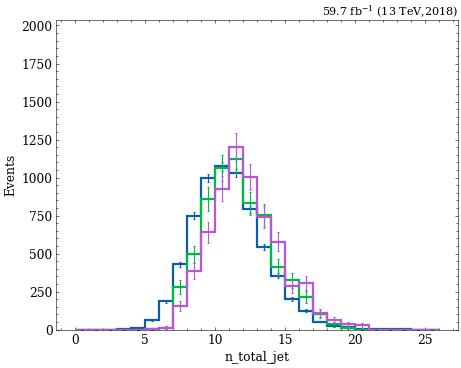

In [99]:
study.quick(
    signal[list(extrema_arg)],
    varlist=['n_total_jet']
)

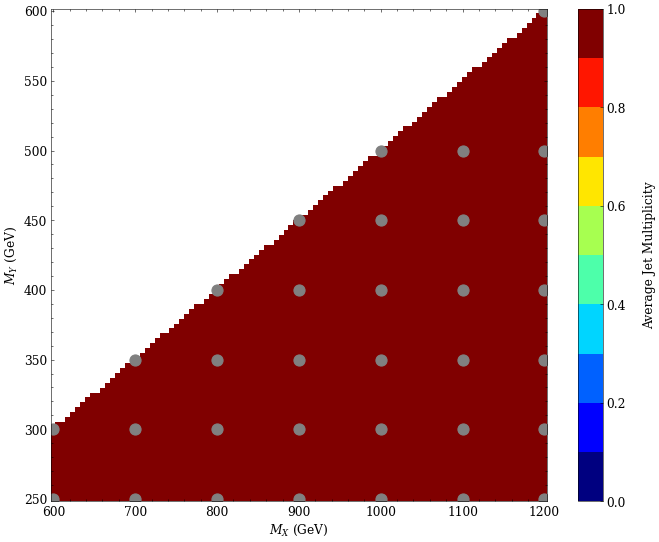

In [109]:
study.mxmy_phase(
    signal,
    f_var=lambda t : ak.mean( (t.n_total_jet >= 8)[t[trigger] == 1] ),
    zlim=np.linspace(0,1,11),
    # zlim=(0,1),
    g_cmap='jet',
    xlabel='$M_{X}$ (GeV)',
    ylabel='$M_{Y}$ (GeV)',
    zlabel='Average Jet Multiplicity',
)

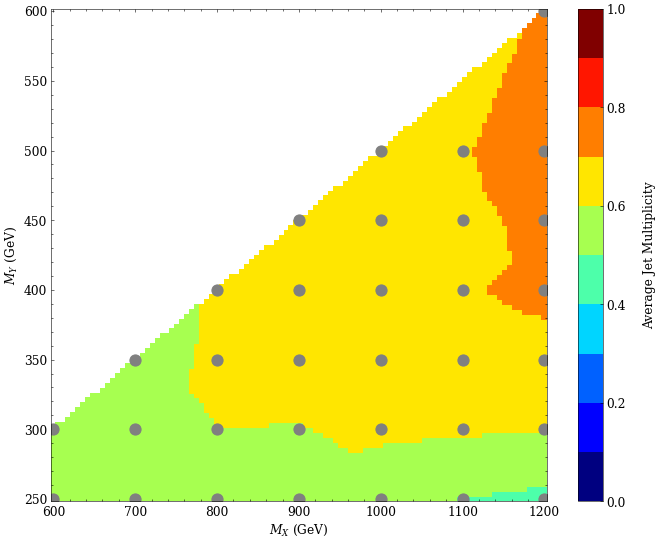

In [110]:
study.mxmy_phase(
    signal,
    f_var=lambda t : ak.mean( (t.n_jet >= 8)[t[trigger] == 1] ),
    zlim=np.linspace(0,1,11),
    # zlim=(0,1),
    g_cmap='jet',
    xlabel='$M_{X}$ (GeV)',
    ylabel='$M_{Y}$ (GeV)',
    zlabel='Average Jet Multiplicity',
)

In [128]:
tree = signal[-3]

In [129]:
build_all_dijets(tree)

100%|██████████| 1/1 [00:00<00:00, 22.56it/s]


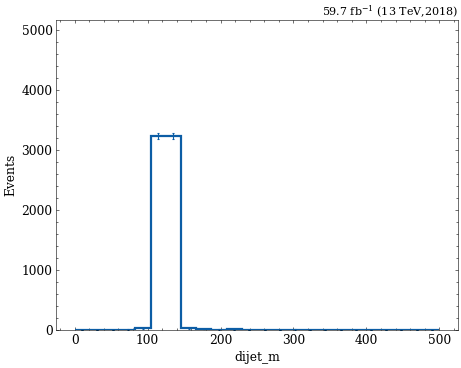

In [137]:
study.quick(
    [tree],
    indices=lambda t : ak.argmin( abs(t.dijet_m-125), axis=-1, keepdims=True ),
    varlist=['dijet_m'],
    binlist=[(0,500,25)]
)

100%|██████████| 1/1 [00:00<00:00, 26.37it/s]


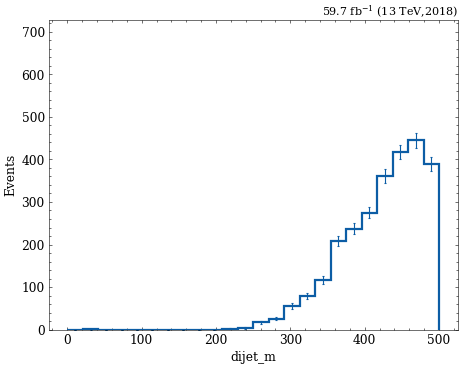

In [138]:
study.quick(
    [tree],
    indices=lambda t : ak.argmax( abs(t.dijet_m-125), axis=-1, keepdims=True ),
    varlist=['dijet_m'],
    binlist=[(0,500,25)]
)